# For Colab

In [ ]:
!wget https://github.com/Chiffaa/Glacier-lakes-detection-using-multi-resolution-input-channels/archive/refs/heads/main.zip

!unzip /content/main.zip

In [ ]:
! pip install rasterio

In [ ]:
# import kaggle.json file before
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
from data_loader import LakesDataset, get_loaders
from architecture import UNet, padding
from train import train, BATCH_SIZE, DEVICE, LEARNING_RATE
from utils import check_accuracy
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Data Import

In [2]:
batch_size = 32

# If the patch_size is given, and the data was still not preprocessed to this size, it is creating a new folder data_patch_size and uses it
train_dataset =LakesDataset(train=True, val=0.2, data_path = '../', patch_size = 256)
val_dataset = LakesDataset(train=False, val=0.2, data_path = '../', patch_size=256)
test_dataset =LakesDataset(train=False, data_path = '../', patch_size = 256)

In [3]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1168
140
699


In [2]:
loaders = get_loaders(patch_size=256, data_path='../', val_split=0.2, batch_size=BATCH_SIZE)

examples_train = iter(loaders['train_loader'])
samples_train, labels_train = next(examples_train)
print(samples_train.shape, labels_train.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])


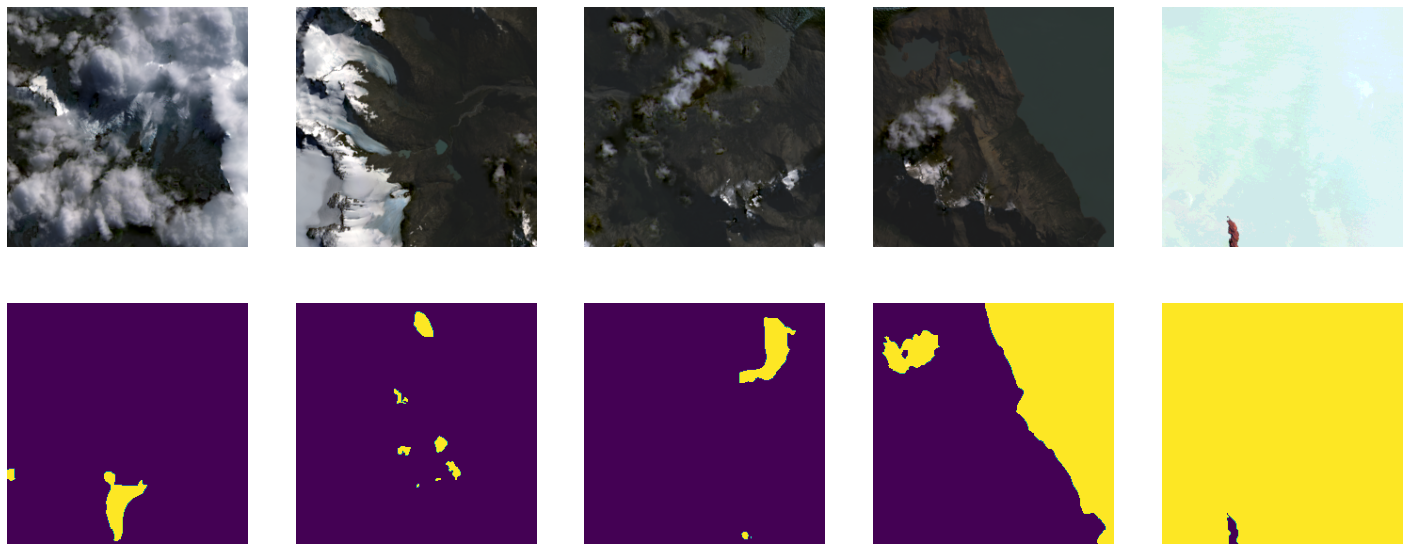

In [5]:
plt.figure(figsize=(25, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples_train[i+7].permute(1,2,0))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(labels_train[i+7].permute(1,2,0))
    plt.axis("off")

# Train

In [3]:
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [4]:
train(model, loaders, loss_fn, optimizer)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elena-golimblevskaya. Use `wandb login --relogin` to force relogin


  3%|▎         | 1/37 [01:31<54:49, 91.38s/it, loss=0.687]

Loss after 0 batch: 0.687


  5%|▌         | 2/37 [02:49<48:43, 83.53s/it, loss=0.672]

Loss after 1 batch: 0.672


  8%|▊         | 3/37 [04:11<46:53, 82.74s/it, loss=0.663]

Loss after 2 batch: 0.663


 11%|█         | 4/37 [05:37<46:19, 84.22s/it, loss=0.689]

Loss after 3 batch: 0.689


 14%|█▎        | 5/37 [07:03<45:08, 84.65s/it, loss=0.664]

Loss after 4 batch: 0.664


 16%|█▌        | 6/37 [08:27<43:41, 84.57s/it, loss=0.653]

Loss after 5 batch: 0.653


 19%|█▉        | 7/37 [09:49<41:56, 83.88s/it, loss=0.648]

Loss after 6 batch: 0.648


 22%|██▏       | 8/37 [10:58<38:10, 78.97s/it, loss=0.646]

Loss after 7 batch: 0.646


 24%|██▍       | 9/37 [12:08<35:36, 76.31s/it, loss=0.638]

Loss after 8 batch: 0.638
